In [31]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.stem.porter import *

% matplotlib inline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

import gc

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [21]:
data_path = 'data/balanced_quotes_clean.csv'

In [6]:
# read the dataset
df = pd.read_csv(data_path)
# view the top rows
df.head()

,quote,label
0,Organized religion is a sham and a crutch for ...,personal
1,The wisdom and experience of older people is a...,personal
2,Regularity in the hours of rising and retiring...,personal
3,Miracles in the sense of phenomena we cannot e...,personal
4,The U.S. states that allow for citizens initia...,personal


In [7]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [12]:
# remove any handles (@user)
df['tidy_quote'] = np.vectorize(remove_pattern)(df['quote'], "@[\w]*")

# remove special characters, numbers, punctuations
df['tidy_quote'] = df['tidy_quote'].str.replace("[^a-zA-Z#]", " ")

df['tidy_quote'] = df['tidy_quote'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

tokenized_quote = df['tidy_quote'].apply(lambda x: x.split())

for i in range(len(tokenized_quote)):
    tokenized_quote[i] = ' '.join(tokenized_quote[i])

df['quote'] = tokenized_quote
del df['tidy_quote']
gc.collect()

/var/folders/hm/s_yl7r210ys8ncbf6rq8kbnm0000gp/T/ipykernel_7680/3409696169.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tidy_quote'] = df['tidy_quote'].str.replace("[^a-zA-Z#]", " ")


14

In [13]:
df.head()

,quote,label
0,Organized religion sham crutch weak minded peo...,personal
1,wisdom experience older people resource inesti...,personal
2,Regularity hours rising retiring perseverance ...,personal
3,Miracles sense phenomena cannot explain surrou...,personal
4,states that allow citizens initiatives tend ha...,personal


In [14]:
df['category_id'] = df['label'].factorize()[0]
category_id_df = df[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)
df.tail()

,quote,label,category_id
42025,really lasted whole game because really untouc...,emotional,4
42026,beginning there word word word make what good ...,emotional,4
42027,best artist that thought alone Which contained...,emotional,4
42028,California crunch really result enough power g...,emotional,4
42029,have really amazing club contemporary little s...,emotional,4


In [15]:
label_to_ix = {}
for label in df.label:
    for word in label.split():
        if word not in label_to_ix:
            label_to_ix[word] = len(label_to_ix)
labels_text = list(label_to_ix.keys())
num_labels = len(labels_text)
labels_text

['personal', 'thoughtful', 'work', 'aspirations', 'emotional']

In [19]:
tfidf = TfidfVectorizer(lowercase=True, sublinear_tf=True, min_df=56, norm='l2', encoding='latin-1', ngram_range=(1, 2),
                        stop_words=list(ENGLISH_STOP_WORDS))

features = tfidf.fit_transform(df.quote).toarray()
labels = df.category_id
features.shape

(42030, 1284)

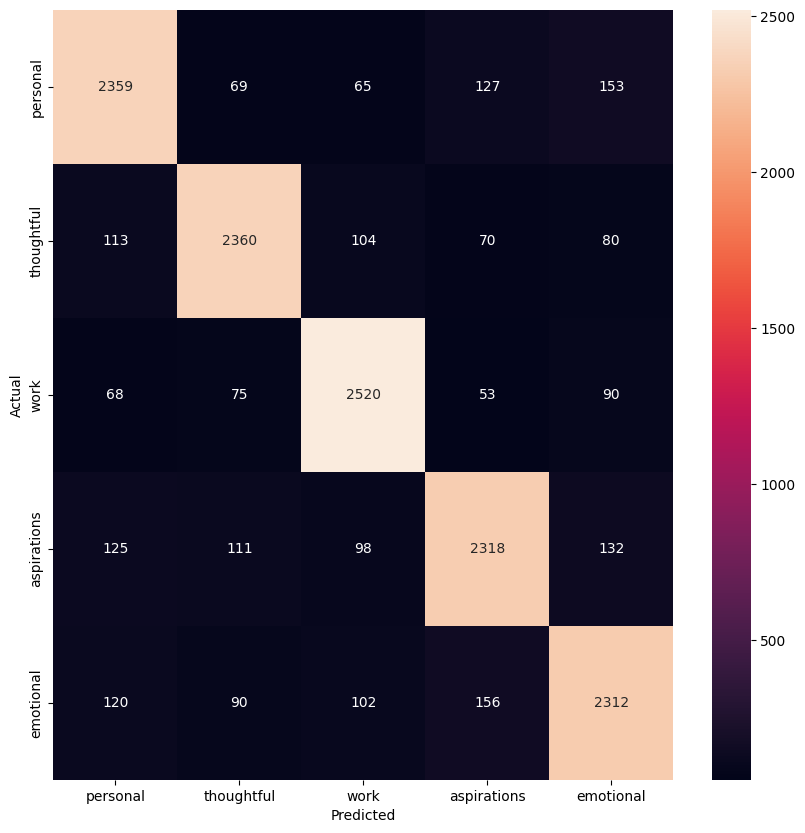

In [22]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index,
                                                                                 test_size=0.33, random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [25]:
print(metrics.classification_report(y_test, y_pred, target_names=df['label'].unique()))

              precision    recall  f1-score   support

    personal       0.85      0.85      0.85      2773
  thoughtful       0.87      0.87      0.87      2727
        work       0.87      0.90      0.88      2806
 aspirations       0.85      0.83      0.84      2784
   emotional       0.84      0.83      0.83      2780

    accuracy                           0.86     13870
   macro avg       0.86      0.86      0.86     13870
weighted avg       0.86      0.86      0.86     13870



In [26]:
# train test split
train, test = train_test_split(df, test_size=0.2, stratify=df['category_id'], random_state=21)

# get the shape of train and test split.
train.shape, test.shape

((33624, 3), (8406, 3))

In [33]:
# define the stages of the pipeline
pipeline = Pipeline(steps=[('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=56, norm='l2',
                                                     encoding='latin-1', ngram_range=(1, 2),
                                                     stop_words=list(ENGLISH_STOP_WORDS))),
                           ('model', LinearSVC())])

# fit the pipeline model with the training data
pipeline.fit(train.quote, train.category_id)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(encoding='latin-1', min_df=56,
                                 ngram_range=(1, 2),
                                 stop_words=['off', 'one', 'so', 'why', 'is',
                                             'therefore', 'as', 'even',
                                             'between', 'hundred', 'anything',
                                             'once', 'everywhere', 'toward',
                                             'through', 'anywhere', 'always',
                                             'however', 'mostly', 'will', 'him',
                                             'via', 'five', 'therein',
                                             'everything', 'onto', 'herein',
                                             'thence', 'next', 'should', ...],
                                 sublinear_tf=True)),
                ('model', LinearSVC())])

In [34]:
quote = ['amazing performer Very temperamental spent time trailer']

# predict the label using the pipeline
ans = pipeline.predict(quote)
print(labels_text[int(ans)])

emotional


In [35]:
# dump the pipeline model
joblib.dump(pipeline, 'model/text_classification.pkl')

['model/text_classification.pkl']

In [37]:
# sample tweet text
quote = [
    'want talk about intelligence matters will however that intelligence community estimates should become public this city Congress']

modelp = open('model/text_classification.pkl', 'rb')
pipeline = joblib.load(modelp)


def predict(pipeline, quote):
    # predict on the sample tweet text
    ans = pipeline.predict(quote)
    return labels_text[int(ans)]


resp = predict(pipeline, quote)
resp

'thoughtful'